### 1 Setting up environment and importing libraries

In this segment, we install the libraries required and set up the environment to train the models. Please choose a GPU runtime .

In [1]:
# install required libraries
#!pip install transformers timm
#%pip install vl_model



In [2]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn import preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import cv2
from keras.models import Model
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

import os
from os import listdir
# Analyse des résultats
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Common configurations to be used throughout the notebook

In [3]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set random seeds for repeatability
import numpy as np
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [5]:
seed_val = 0
set_seed(seed_val)

Defines the paths to read data from, as well as training parameters which we are going to use for all three models.



In [6]:
HOME_FOLDER = './Flipkart/' 
IMAGE_FOLDER = HOME_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

### 2. Importation du fichier

In [7]:
df_X_train= pd.read_csv(HOME_FOLDER + 'train.csv')
df_y_train= pd.read_csv(HOME_FOLDER + 'train_labels.csv')
df_X_val= pd.read_csv(HOME_FOLDER + 'validation.csv')
df_y_val= pd.read_csv(HOME_FOLDER + 'validation_labels.csv')
df_X_test= pd.read_csv(HOME_FOLDER + 'test.csv')
df_y_test= pd.read_csv(HOME_FOLDER + 'test_labels.csv')

In [8]:
df_X_train.img_path = df_X_train.img_path.apply(lambda x: IMAGE_FOLDER+str(x) )
df_X_val.img_path = df_X_val.img_path.apply(lambda x: IMAGE_FOLDER+str(x) )
df_X_test.img_path = df_X_test.img_path.apply(lambda x: IMAGE_FOLDER+str(x) )
df_y_train["label"]=df_y_train["label"].astype(str)
df_y_val["label"]=df_y_val["label"].astype(str)
df_y_test=df_y_test["label"].astype(str)
df_X_train["text"] = df_X_train["description"]
df_X_val["text"] = df_X_val["description"]
df_X_test["text"] = df_X_test["description"]

### 3. Création du Data Generator

In [9]:
# Créer un générateur d'images
datagen = ImageDataGenerator(rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True)

Nous allons finaliser notre jeu de données à travers la génération de nouvelles images pour nos différentes séparations du jeu de données.

Pour cela, l'utilisation du Data Generator créé en amont sera nécessaire à cette finalisation

In [10]:
# Générer de nouvelles images pour les ensembles d'entraînement
#df_train=pd.DataFrame({"img_path": df_X_train, "label": df_y_train})
# Concatenate along columns axis to create df_train
df_train = pd.concat([df_X_train, df_y_train], axis=1)
train_generator = datagen.flow_from_dataframe(dataframe = df_train,
                                              x_col="img_path", 
                                              y_col="label", 
                                              target_size=(224,224), 
                                              batch_size=32, 
                                              class_mode="categorical")

# Générer de nouvelles images pour l'ensemble de test
#df_test = pd.DataFrame({"img_path": df_X_test, "label": df_y_test})
df_test =pd.concat([df_X_test, df_y_test], axis=1)
test_generator = datagen.flow_from_dataframe(dataframe= df_test, 
                                             x_col="img_path", 
                                             y_col="label", 
                                             target_size=(224,224), 
                                             batch_size=32, 
                                             class_mode="categorical")

# Générer de nouvelles images pour l'ensemble de validation
#df_val = pd.DataFrame({"img_path": df_X_val, "label": df_y_val})
df_val=pd.concat([df_X_val, df_y_val], axis=1)
val_generator = datagen.flow_from_dataframe(dataframe= df_val, 
                                             x_col="img_path", 
                                             y_col="label", 
                                             target_size=(224,224), 
                                             batch_size=32, 
                                             class_mode="categorical")

Found 703 validated image filenames belonging to 7 classes.
Found 174 validated image filenames belonging to 7 classes.


Found 173 validated image filenames belonging to 7 classes.


## III. Modélisation

Afin de procéder à notre modélisation, nous allons prendre la décision de modéliser 3 modèles :
- un réseau CNN créé à notre niveau avec les différentes couches,
- le modèle de Transfer Learning VGG19 que nous avons testé lors de l'étude de faisabilité,
- le modèle de Transfer Learning RESNET50.

Afin d'effectuer une étude identique pour ces derniers, nous allons entraîner ces modèles sur un nombre d'epochs similaires, à savoir 12 epochs.
Nous allons également mettre en place un EarlyStop avec une patience de 3 epochs sur le val_loss uniquement sur les modèles de Transfer Learning, cela nous permettra d'analyser l'impact du Early Stop sur un entrainement.

Pour nos modèles de Transfer Learning, nous allons prendre l'initiative d'ajouter quelques couches supplémentaires.
Ces deux modèles auront des modifications identiques afin d'obtenir le meilleur modèle.



In [11]:
# Création du Early Stop
early_stop = EarlyStopping(monitor='val_loss',patience=3)

# Définir le nombre d'itérations d'entraînement
epochs = 1

### 1. CNN

In [12]:
# Créer le modèle
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()







Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)     

In [13]:
import time

start_time = time.time()
# Entraîner le modèle sur les données d'entraînement
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_batch_size=32)

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")



22/22 [==============================] - 19s 822ms/step - loss: 10.7839 - accuracy: 0.1522 - val_loss: 1.9620 - val_accuracy: 0.1850
Temps d'exécution de la cellule :  19.79913878440857  secondes


Notre premier modèle indique un score de 0.43. Nous constatons une certaine dégradation de notre modèle avec un score assez faible. Ce dernier ne sera pas conservé.

A présent, nous allons procédr à l'utilisation des modèles de Transfer Learning tout y intégrant un EarlyStop.

### 2. VGG 19

In [14]:
from tensorflow.keras.layers import Input

# Charger le modèle pré-entrainé VGG19
inputs = Input(shape=(224, 224, 3))
vgg_model = VGG19(include_top=False, weights=None, input_tensor=inputs, classes = 7)
outputs = vgg_model.output

# Ajouter des couches supplémentaires
x = MaxPooling2D(pool_size=(2, 2))(outputs) # couche de pooling
x = Flatten()(x) # couche de flattening
x = Dense(512, activation='relu')(x) # couche dense avec 128 neurones et une fonction d'activation relu
predictions = Dense(7, activation='softmax')(x) # couche dense de sortie avec 7 neurones et une fonction d'activation softmax

# Construire le modèle complet
model = Model(inputs=inputs, outputs=predictions)

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

# Entraîner le modèle sur les données d'entraînement
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_batch_size=32,
                    callbacks=[early_stop])

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Ce modèle présente un score très faible avec environ 0.15. Nous n'allons pas conserver ce modèle.

De plus, ce modèle présente un délai  très long à la différence du précédent modèle.
L'utilisation du Early Stop a permis de stopper l'entrainement au moment le plus opportun.


### 3. RESNET 50

In [15]:
# Charger le modèle pré-entrainé RESNET50
inputs = Input(shape=(224, 224, 3))
resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, classes=7)
outputs = resnet_model.output

# Ajouter des couches supplémentaires
x = MaxPooling2D(pool_size=(2, 2))(outputs) # couche de pooling
x = Flatten()(x) # couche de flattening
x = Dense(128, activation='relu')(x) # couche dense avec 128 neurones et une fonction d'activation relu
predictions = Dense(7, activation='softmax')(x) # couche dense de sortie avec 7 neurones et une fonction d'activation softmax

# Construire le modèle complet
model = Model(inputs=inputs, outputs=predictions)

# Compiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

# Entraîner le modèle sur les données d'entraînement
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_batch_size=32,
                    callbacks=[early_stop])

end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

Ce modèle présente les meilleurs résultats avec un accuracy de 0.47 ce qui représente un très bon score. Ce modèle sera conservé pour notre phase d'analyse et de test.
A présent, nous allons procéder à l'analyse de notre meilleur modèle, à savoir le RESNET50.

Pour cela, le jeu de validation (val_generator) sera utilisé pour l'évaluation.

Enfin, nous pourrons procéder à la phase de test de notre modèle grâce à notre jeu de test. 

<Axes: >

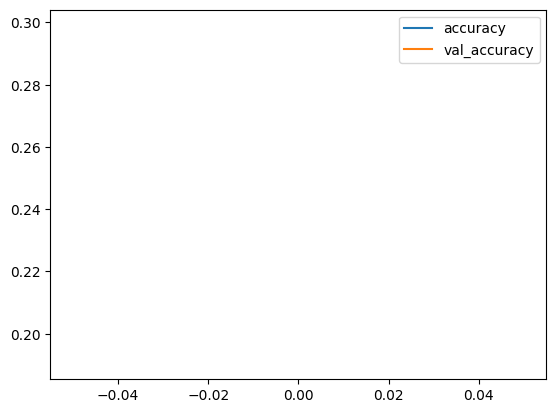

In [16]:
losses = pd.DataFrame(model.history.history)

losses[['accuracy','val_accuracy']].plot()

<Axes: >

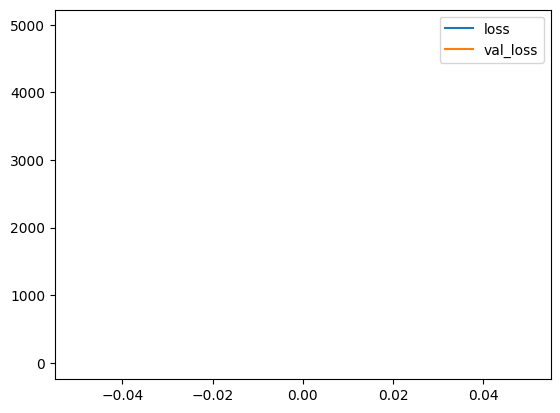

In [17]:
losses[['loss','val_loss']].plot()

In [18]:
# Calculer la perte et l'exactitude sur l'ensemble de validation
test_results = model.evaluate(test_generator)

# Afficher les résultats
print('Perte de validation:', test_results[0])
print('Exactitude de validation:', test_results[1])

6/6 [==============================] - 6s 974ms/step - loss: 5617.4790 - accuracy: 0.1609
Perte de validation: 5617.47900390625
Exactitude de validation: 0.16091954708099365


6/6 [==============================] - 7s 909ms/step


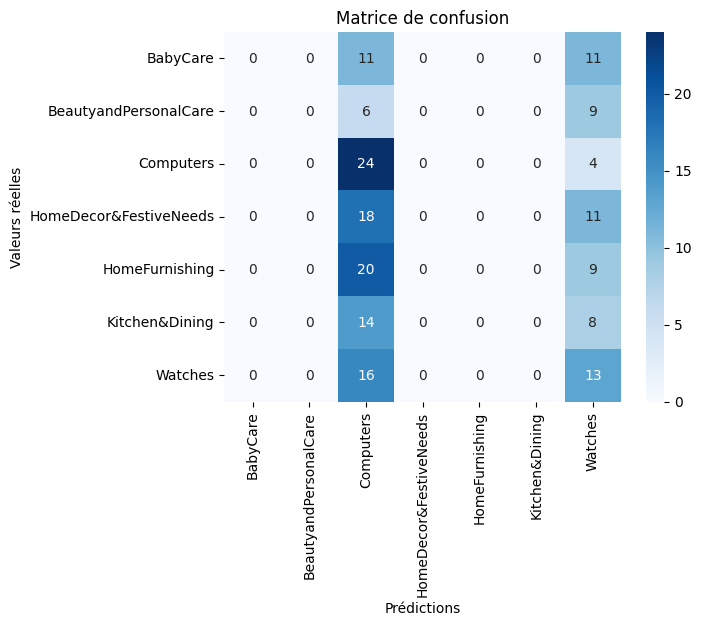

                        precision    recall  f1-score   support

              BabyCare       0.00      0.00      0.00        22
 BeautyandPersonalCare       0.00      0.00      0.00        15
             Computers       0.22      0.86      0.35        28
HomeDecor&FestiveNeeds       0.00      0.00      0.00        29
        HomeFurnishing       0.00      0.00      0.00        29
        Kitchen&Dining       0.00      0.00      0.00        22
               Watches       0.20      0.45      0.28        29

              accuracy                           0.21       174
             macro avg       0.06      0.19      0.09       174
          weighted avg       0.07      0.21      0.10       174



In [19]:
def evaluate_model(model, test_generator):
    # Obtenir les prédictions pour l'ensemble de test
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convertir les étiquettes en vecteurs de classe
    y_true = test_generator.classes

    # Obtenir les noms de classe pour les étiquettes réelles
    class_names = list(test_generator.class_indices.keys())

    # Calculer la matrice de confusion
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)

    # Afficher la matrice de confusion sous forme graphique
    sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, cmap='Blues', annot=True, fmt='d')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.show()

    # Afficher le rapport de classification
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


# Appel de notre fonction    
evaluate_model(model, test_generator)

Exceute the cells below to see a random label, text, image triplet from the train dataset

In [20]:
import matplotlib.pyplot as plt

def show_sample(df,row_num):
    sample_row = df.iloc[row_num]
    print('Index:', row_num)
    print('product_name:', sample_row['product_name'])
    print('description:', sample_row['description'])
    image_path = sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

Index: 498
product_name: Lal Haveli Traditional Hand Crafted Beautiful Iron Musician 5 Pcs Set Showpiece  -  33 cm
description: buy lal haveli traditional hand crafted beautiful iron musician pcs set showpiece cm for rs online lal haveli traditional hand crafted beautiful iron musician pcs set showpiece cm at best prices with free shipping cash on delivery only genuine products day replacement guarantee Lal Haveli Traditional Hand Crafted Beautiful Iron Musician 5 Pcs Set Showpiece  -  33 cm


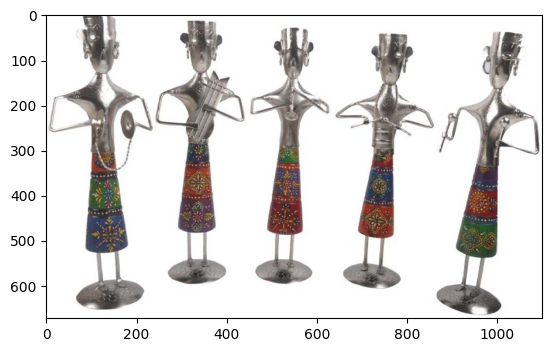

In [21]:
from random import randint

show_sample(df_X_train,randint(0, len(df_X_train)))

## BERT
The first model which we are going to train is a BERT model which only uses the text from the data.

In [22]:
## training parameters to be used for all models ##
num_train_epochs = 1
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

### Dataset
Since we are training a text only model, the dataset which we fit into the model only requires two attributes: **text** and **label**.

In [23]:
class TextDataset(Dataset):
    def __init__(self, df, label_to_id, text_field="text", label_field="label"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.text_field = text_field
        self.label_field = label_field
                          
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        
        return text, label

    def __len__(self):
        return self.df.shape[0]

### Model
The model uses BERT to encode the text, and feeds the encodings (a 768 dimension vector) into a fully connected linear layer with 10 outputs (one for each class label).

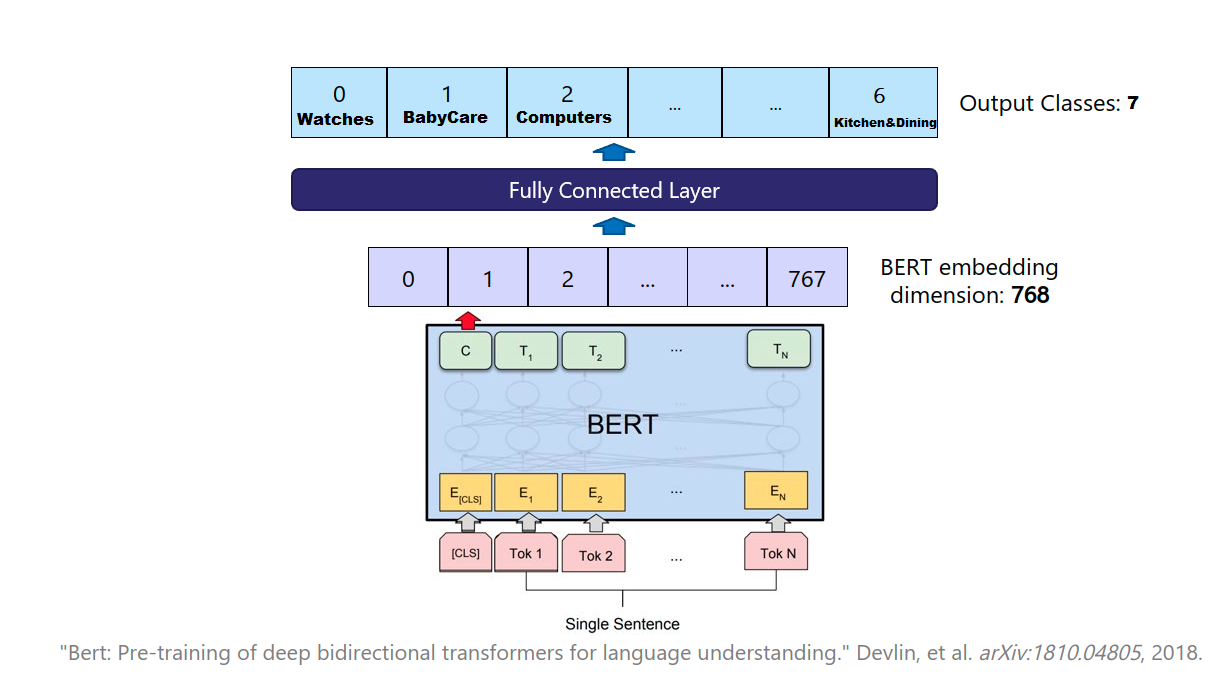

In [24]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [25]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)
        
    
    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits

In [26]:
# create the model
num_out_labels=7
bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

In [27]:
df_y_test

0      HomeDecor&FestiveNeeds
1                    BabyCare
2      HomeDecor&FestiveNeeds
3                   Computers
4                     Watches
                ...          
169                  BabyCare
170                  BabyCare
171            Kitchen&Dining
172            HomeFurnishing
173            HomeFurnishing
Name: label, Length: 174, dtype: object

In [28]:
# Assuming id_to_label is a dictionary that maps numerical IDs to labels
label_to_id = {"Kitchen&Dining": 0, "BeautyandPersonalCare": 1, "BabyCare": 2, "Watches": 3, "HomeDecor&FestiveNeeds": 4, "HomeFurnishing": 5, "Computers": 6}
# Créer le dictionnaire inverse id_to_label
id_to_label = {v: k for k, v in label_to_id.items()}
# Replace numerical IDs with labels in df_X_test['label']
# Convertir les valeurs de la colonne 'label' en entiers

df_X_train['label'] =df_y_train['label']
df_X_val['label'] =df_y_val['label']
df_X_test['label'] =df_y_test


In [29]:
df_y_val

,label
0,Watches
1,Watches
2,Computers
3,Computers
4,BabyCare
...,...
168,Computers
169,Computers
170,BeautyandPersonalCare
171,Watches


In [30]:
df_X_train["label"]

0             Kitchen&Dining
1      BeautyandPersonalCare
2                   BabyCare
3             Kitchen&Dining
4                    Watches
               ...          
698                Computers
699                 BabyCare
700                 BabyCare
701                 BabyCare
702                Computers
Name: label, Length: 703, dtype: object

### Training
Load the data using the text dataset, feed it into a data loader for random sampling, and train the model

In [31]:
set_seed(seed_val)

train_dataset = TextDataset(df=df_X_train, label_to_id=label_to_id, text_field='text', label_field='label')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bert_model.train()


start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()        
        b_logits = bert_model(text=b_inputs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()
    
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 74.06110715866089
    avg_epoch_loss = 1.6832069808786565
    learning rate = 0.0
Training completed in  70.85514679999324 seconds


### Testing
Predict on the test set

In [32]:
bert_prediction_results = []

test_dataset = TextDataset(df=df_X_val, label_to_id=label_to_id, text_field='text', label_field='label')
test_sampler = SequentialSampler(test_dataset)        
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size, 
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  bert_model.eval()

  b_text, b_labels = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = bert_model(text=b_inputs)
      b_logits = b_logits.detach().cpu()

  bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

bert_prediction_labels = [id_to_label[p] for p in bert_prediction_results]

  0%|          | 0/11 [00:00<?, ?it/s]

Generate the classification report by comparing the predictions from the model with the true labels

In [33]:
df_y_val.value_counts()

label                 
Computers                 27
HomeFurnishing            27
BabyCare                  26
BeautyandPersonalCare     25
Watches                   25
HomeDecor&FestiveNeeds    24
Kitchen&Dining            19
Name: count, dtype: int64

In [34]:
bert_class_report = classification_report(df_y_val, bert_prediction_labels, output_dict=True)
bert_class_report['training_time (seconds)'] = bert_training_time

with open(RESULTS_FOLDER + 'bert_class_report.json', 'w') as f:
  json.dump(bert_class_report, f)

print(bert_class_report['accuracy'])

0.6705202312138728


In [35]:
# while True:pass

## BERT + ResNet-50
The next model that we are training uses a combination of BERT and ResNet-50 to encode the text and images, respectively.

### Dataset
Unlike the previous Dataset used for BERT, we include images in this dataset by reading the image files and applying a series of transformations to them so that they can fit into the ResNet model. 

In [36]:
class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

                    
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = self.df.at[index, self.image_path_field]

        
        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

### Model
The original ResNet model consists of a fully connected layer with 1000 classes at the end, to show the scores of each image belonging to that class. However, our output classes are different and we want to use the image features before the fully connected layer instead of the 1000-class output probabilities. Therefore, we "extract" this model out of the original ResNet model architecture by leaving out the fully connected layer.


After that, we pair the extracted ResNet model with a BERT model and add a 10-class linear layer on top of them, like we did for the previous BERT classifier.


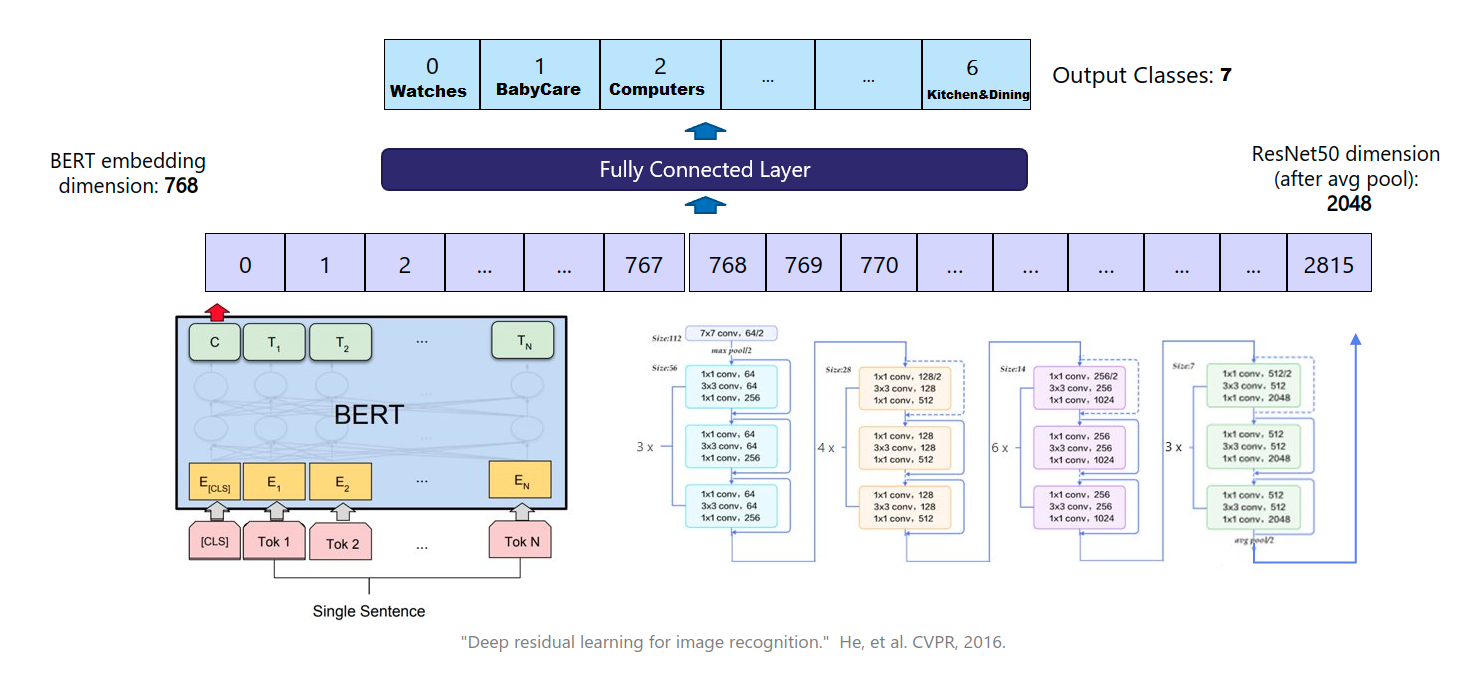


The ResNet-50 model is trained on imagenet data to classify images into 1000 classes, therefore the last layer is a fully connected layer with 1000 output nodes. This output is not useful to us since our output classes are different. Therefore, we need to strip off this fully connected layer and use the features after the last average pooling layer. This can be done by copying the layers and weights to another network and leave out the last layer.

![](https://drive.google.com/uc?export=view&id=1ivYlubrhvY00P7b2SYLfpRSF3XxJUbfh)

In [37]:
# extract layers of resnet-50 to build a new model

import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)

        
    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [38]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [39]:
# last output layer name for resnet is named 'layer4', dim 2048*7*7
# last layer name before fc is named 'avgpool', dim 2048*1*1 -> needs to be flattened
# reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048
        
        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)

        logits = self.classifier(features)

        return logits

In [40]:
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

### Training
Similar to BERT training, but we take in images as an additional input

In [41]:
df_X_train['text']

0      printland pmr ceramic mug ml price rs printlan...
1      e l f cosmetics studio brow kit ash brow makeu...
2      key features of chokree baby girl s girl s a l...
3      key features of ocean vglass pack of ocean vgl...
4      hmt hmtwhq analog watch for men buy hmt hmtwhq...
                             ...                        
698    buy asus rt n lx mbps wireless router only for...
699    key features of shaun printed baby boy s yello...
700    specifications of toffyhouse baby boy s sleeps...
701    buy wallmantra medium vinyl stickers sticker f...
702    buy dizionario mini perfume fan cooling fancoo...
Name: text, Length: 703, dtype: object

In [42]:
## training loop
set_seed(seed_val)

train_dataset = ResNetDataset(df=df_X_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

resnet_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels, b_imgs = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()        
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()
        
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 72.3388866186142
    avg_epoch_loss = 1.6440656049685045
    learning rate = 0.0
Training completed in  157.23987759999727 seconds


### Testing

In [43]:
# testing loop

resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_X_val, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)        
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size, 
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

  0%|          | 0/11 [00:00<?, ?it/s]

Generate the classification report

In [44]:
resnet_class_report = classification_report(df_y_val['label'], resnet_prediction_labels, output_dict=True)
resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

0.7283236994219653


## ALBEF
The last model that we are training is the ALBEF joint-encoder model which aligns the text and image features.

### ALBEF-specific setup
This section creates the folder structure and download the necessary files required to train an ALBEF model.

In [45]:
ALBEF_FOLDER = HOME_FOLDER + 'ALBEF/'
os.makedirs(ALBEF_FOLDER, exist_ok=True)

In [46]:
# download pre-trained ALBEF model and required ALBEF files from ALBEF's official repo (only need to do this once to save it in your gdrive)
#!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py -O $ALBEF_FOLDER/vit.py
#!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py -O $ALBEF_FOLDER/tokenization_bert.py
#!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/xbert.py -O $ALBEF_FOLDER/xbert.py


In [47]:
%pip install transformers --upgrade


  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.1
    Uninstalling transformers-4.36.1:
      Successfully uninstalled transformers-4.36.1
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [48]:
# replace all occurrences of tokenizer_class with processor_class in xbert.py to make it compatible with newer transformers version
# if you don't do this step, you will need to install transformers==4.8.1 as specified by the requirements in the ALBEF repo

#!sed -i 's/tokenizer_class/processor_class/g' $ALBEF_FOLDER/xbert.py
#!(Get-Content "$ALBEF_FOLDER/xbert.py") -replace 'tokenizer_class', 'processor_class' | Set-Content "$ALBEF_FOLDER/xbert.py"


In [49]:
# add path to downloaded ALBEF files
import sys
sys.path.append(ALBEF_FOLDER)

#import libraries required for ALBEF
from vit import VisionTransformer
from xbert import BertConfig as AlbefBertConfig, BertModel as AlbefBertModel
from functools import partial

### Dataset
Same as the BERT-ResNet Dataset which contains **text**, **images** and **labels**. The only difference here is the image size (ResNet - 224, ALBEF - 256).

In [50]:
class AlbefDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ALBEF settings
        self.img_size = 256
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

                    
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = self.df.at[index, self.image_path_field]

        
        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

### Model
ALBEF also uses BERT as its text encoder. Its image encoder is actually a VisionTransformer model.
We use the joint text-image encoder to encode both the text and images, and as with the previous two models, add a linear fully connected layer to it.


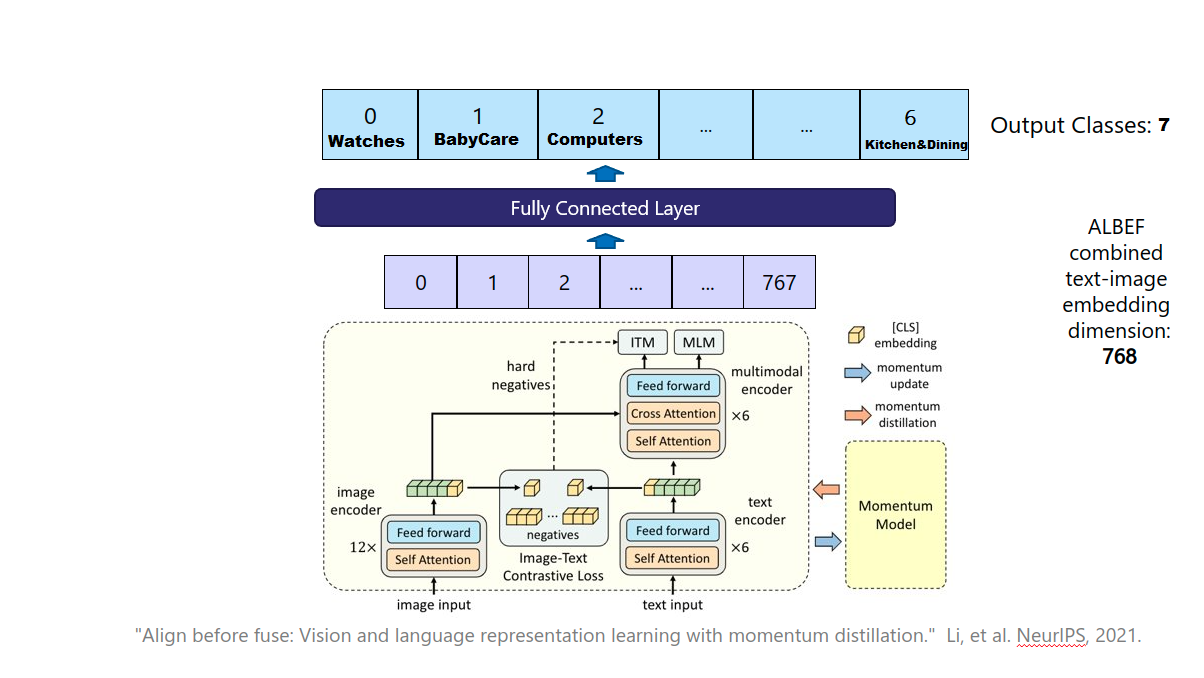

In [51]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [52]:
class AlbefModel(nn.Module):

    def __init__(self, bert_config, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AlbefBertModel.from_pretrained(
            text_pretrained, config=bert_config, add_pooling_layer=False)

        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)
        
    
    def forward(self, text, image):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image_embeds.device)
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                   encoder_hidden_states=image_embeds, encoder_attention_mask=image_atts, return_dict=True
                                   )
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        return logits

Because ALBEF aligns the BERT and VisionTransformers features, it has its own BERT configuration. We download both this configuration and the pretrained model from Salesforce's GitHub and web pages in the function below which loads a pretrained model.

In [53]:
from urllib.request import urlretrieve

def load_albef_pretrained(num_out_labels):
    tmp_directory = './tmp/albef'
    os.makedirs(tmp_directory, exist_ok=True)

    albef_bert_config_fp = os.path.join(tmp_directory, 'config_bert.json')
    albef_model_fp = os.path.join(tmp_directory, 'ALBEF.pth')

    if not os.path.exists(albef_bert_config_fp):
        urlretrieve("https://raw.githubusercontent.com/salesforce/ALBEF/main/configs/config_bert.json", albef_bert_config_fp)

    if not os.path.exists(albef_model_fp):
        urlretrieve("https://storage.googleapis.com/sfr-pcl-data-research/ALBEF/ALBEF_4M.pth", albef_model_fp)

    albef_bert_config = AlbefBertConfig.from_json_file(albef_bert_config_fp)
    albef_model = AlbefModel(bert_config=albef_bert_config, num_labels=num_out_labels)

    albef_checkpoint = torch.load(albef_model_fp, map_location='cpu')
    albef_state_dict = albef_checkpoint['model']

    for key in list(albef_state_dict.keys()):
        if 'bert' in key:
            encoder_key = key.replace('bert.', '')
            albef_state_dict[encoder_key] = albef_state_dict[key]
            del albef_state_dict[key]

    msg = albef_model.load_state_dict(albef_state_dict, strict=False)
    print("ALBEF checkpoint loaded from ", albef_model_fp)
    print(msg)
    return albef_model

In [54]:
albef_model = load_albef_pretrained(num_out_labels=num_out_labels)
albef_model = albef_model.to(device)

ALBEF checkpoint loaded from  ./tmp/albef\ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

### Training

In [55]:
## training loop
set_seed(seed_val)

train_dataset = AlbefDataset(df=df_X_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(albef_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

albef_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels, b_imgs = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        albef_model.zero_grad()        
        b_logits = albef_model(text=b_inputs, image=b_imgs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()
        
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
albef_training_time = end- start
print('Training completed in ', albef_training_time, 'seconds')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 71.6424241065979
    avg_epoch_loss = 1.6282369115135886
    learning rate = 0.0
Training completed in  371.7619483000017 seconds


### Testing

In [56]:
# testing loop

albef_prediction_results = []

test_dataset = AlbefDataset(df=df_X_val, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)        
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size, 
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  albef_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = albef_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()



  albef_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

albef_prediction_labels = [id_to_label[p] for p in albef_prediction_results]


  0%|          | 0/11 [00:00<?, ?it/s]

Generate the classification report

In [57]:
albef_class_report = classification_report(df_y_val['label'], albef_prediction_labels, output_dict=True)
albef_class_report['training_time (seconds)'] = albef_training_time

with open(RESULTS_FOLDER + 'albef_class_report.json', 'w') as f:
  json.dump(albef_class_report, f)

print(albef_class_report['accuracy'])


0.7630057803468208


faire un test simple 

Index: 98
product_name: AKUP i-loves-music Ceramic Mug
description: key features of akup i loves music ceramic mug pack of mug akup i loves music ceramic mug ml price rs akup ceramic coffee mugs gives you the best quality printed mugs which you can gift to your loved ones we provide good quality of products with packing coffee mugs made of ceramic clay with the volume capacity of ml each you can buy it for yourself to make your moment unforgettable forever specifications product dimensions mugs height cms diameter cms item type coffee mug color multi color material clay finish glossy specialty lovely style wash care remove dirt by using a soft fabric to clean and then wipe with a moist cloth disclaimer the fine design pattern and color tone of the product may vary slightly from that shown in the image however there would not be any compromise in quality brand akup designs co specifications of akup i loves music ceramic mug ml general type mug mug capacity ml material ceramic freezer sa

100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


True Label: Kitchen&Dining
Predicted Label: Kitchen&Dining


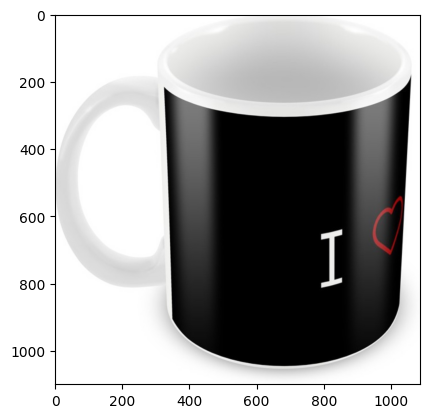

In [58]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

# Assume you have a specific sample index you want to test

sample_index = randint(0, len(df_X_test))
show_sample(df_X_test,sample_index)

# Get the text, label, and image path for the selected sample
sample_text = df_X_test.iloc[sample_index]["text"]
sample_label = df_X_test.iloc[sample_index]["label"]
sample_img_path = df_X_test.iloc[sample_index]["img_path"]

# Tokenizer for BERT
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create a mini-dataset with the selected sample
mini_dataset = AlbefDataset(df=pd.DataFrame({"text": [sample_text], "label": [sample_label], "img_path": [sample_img_path]}),
                            label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')

# Create a dataloader for the mini-dataset
mini_dataloader = DataLoader(dataset=mini_dataset, batch_size=1, shuffle=False)

# Testing loop for the mini-dataset
albef_model.eval()
albef_prediction_results = []

for batch in tqdm(mini_dataloader):
    b_text, _, b_imgs = batch

    b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)
    b_imgs = b_imgs.to(device)
    b_inputs = b_inputs.to(device)

    with torch.no_grad():
        b_logits = albef_model(text=b_inputs, image=b_imgs)
        b_logits = b_logits.detach().cpu()

    albef_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

# Convert predicted labels to their actual labels
albef_prediction_labels = [id_to_label[p] for p in albef_prediction_results]

# Display or use albef_prediction_labels as needed
print(f"True Label: {sample_label}")
print(f"Predicted Label: {albef_prediction_labels[0]}")


## Predict on models trained with 20 epochs
In the previous segments, we trained each model for only 5 epochs due to the tutorial's time constraint. Thus, we cannot see a significant contrast between the accuracies of the models. Training for more epochs will improve the models' accuracies. Therefore, we have trained the models for 20 epochs each and saved them. In this segment, we will load the models and make predictions on the test set to compare their accuracies.

The code in the previous segments have to be reused to load the models. Before executing this step, the following cells must have been executed:
- Setup and common config cells
- ALBEF-specific cells
- ALBEF-loading cells
- Cells containing model code for BERT, BERT-ResNet and ALBEF


This function loads the pretrained model for each of the three model architectures.

In [59]:
def load_trained_models(load_directory, image_model_type):
    label_map_filepath = os.path.join(load_directory, "label_map.json")
    with open(label_map_filepath, 'r') as f:
        label_to_id = json.load(f)

    id_to_label = {v:k for k,v in label_to_id.items()}

    num_labels = len(label_to_id)


    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    model_sd_filepath = os.path.join(load_directory, "state_dict.pt")
    model_sd = torch.load(model_sd_filepath, map_location='cpu')

    if image_model_type is None:
        model = VLBertModel(num_labels=num_labels)
    elif image_model_type.lower() == 'resnet':
        model = BertResNetModel(num_labels=num_labels)
    elif image_model_type.lower() == 'albef':
        model = load_albef_pretrained(num_out_labels=num_labels)

    model.to('cpu') # load all models in cpu first
    model.load_state_dict(model_sd, strict=True)
    model.to(device)

    return model, tokenizer, label_to_id, id_to_label
        

We streamline the three different datasets presented previously into one common VLDataset class which has **text**, **images** and **labels**.

In [60]:
class VLDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field=None, image_model_type=None):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field
        self.image_model_type = image_model_type

        # text only dataset
        if image_model_type is not None:
            
            # ResNet-50 and ALBEF use different image sizes
            if image_model_type.lower() == "resnet":   # ResNet-50 settings
                self.img_size = 224
            elif image_model_type.lower() == "albef":   # ALBEF settings
                self.img_size = 256
        
            self.mean, self.std = (
                0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


            self.train_transform_func = transforms.Compose(
                    [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(self.mean, self.std)
                        ])

            self.eval_transform_func = transforms.Compose(
                    [transforms.Resize(256),
                        transforms.CenterCrop(self.img_size),
                        transforms.ToTensor(),
                        transforms.Normalize(self.mean, self.std)
                        ])


                    
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        # return images only if image model is specified
        if self.image_model_type is not None:
            img_path = self.df.at[index, self.image_path_field]

        
            image = Image.open(img_path)
            if self.train:
                img = self.train_transform_func(image)
            else:
                img = self.eval_transform_func(image)

            return text, label, img
        
        else:
            return text, label

    def __len__(self):
        return self.df.shape[0]

We also streamline the predict function to do prediction on the test set with the loaded models of any of the three model architectures.

In [61]:
## testing loop
def predict(df_test, model, tokenizer, label_to_id, id_to_label, image_model_type):
    prediction_results = []

    test_dataset = VLDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path', image_model_type=image_model_type)
    test_sampler = SequentialSampler(test_dataset)        
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size, 
                                sampler=test_sampler)


    for batch in tqdm(test_dataloader):
        model.eval()

        if image_model_type is None:
          b_text, b_labels = batch
          b_imgs = None
        else:  
          b_text, b_labels, b_imgs = batch

        b_inputs = tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        if b_imgs is not None:
          b_imgs = b_imgs.to(device)

        with torch.no_grad():
            if b_imgs is not None:
              b_logits = model(text=b_inputs, image=b_imgs)
            else:
              b_logits = model(text=b_inputs)
              
            b_logits = b_logits.detach().cpu()



        prediction_results += torch.argmax(b_logits, dim=-1).tolist()

    prediction_labels = [id_to_label[p] for p in prediction_results]

    print(accuracy_score(df_test['label'], prediction_labels))

    return prediction_labels

### Predict with loaded BERT model

In [62]:
bert_load_directory = TRAINED_MODELS_FOLDER + 'BERT'

bert_model, bert_tokenizer, label_to_id1, id_to_label1 = load_trained_models(bert_load_directory, image_model_type=None)

In [63]:
label_to_id1

{'Kitchen&Dining': 0,
 'BeautyandPersonalCare': 1,
 'BabyCare': 2,
 'Watches': 3,
 'HomeDecor&FestiveNeeds': 4,
 'HomeFurnishing': 5,
 'Computers': 6}

In [64]:
label_to_id

{'Kitchen&Dining': 0,
 'BeautyandPersonalCare': 1,
 'BabyCare': 2,
 'Watches': 3,
 'HomeDecor&FestiveNeeds': 4,
 'HomeFurnishing': 5,
 'Computers': 6}

In [65]:

bert_predictions = predict(df_X_train.copy(), bert_model, bert_tokenizer, label_to_id, id_to_label, image_model_type=None)

100%|██████████| 44/44 [00:19<00:00,  2.22it/s]

1.0


### Predict with loaded BERT-ResNet model

In [66]:
bert_resnet_load_directory = TRAINED_MODELS_FOLDER + 'BERT_ResNet'
bert_resnet_model, bert_resnet_tokenizer, label_to_id, id_to_label = load_trained_models(bert_resnet_load_directory, image_model_type='resnet')
bert_resnet_predictions = predict(df_X_test.copy(), bert_resnet_model, bert_resnet_tokenizer, label_to_id, id_to_label, image_model_type='resnet')

100%|██████████| 11/11 [00:13<00:00,  1.23s/it]

0.9482758620689655


In [67]:
bert_resnet_predictions

['HomeDecor&FestiveNeeds',
 'BabyCare',
 'Kitchen&Dining',
 'Computers',
 'Watches',
 'Kitchen&Dining',
 'HomeFurnishing',
 'HomeFurnishing',
 'Kitchen&Dining',
 'Watches',
 'Computers',
 'HomeDecor&FestiveNeeds',
 'HomeDecor&FestiveNeeds',
 'Kitchen&Dining',
 'Computers',
 'Computers',
 'BeautyandPersonalCare',
 'HomeDecor&FestiveNeeds',
 'BeautyandPersonalCare',
 'Watches',
 'BeautyandPersonalCare',
 'Kitchen&Dining',
 'BabyCare',
 'Kitchen&Dining',
 'Computers',
 'BeautyandPersonalCare',
 'Kitchen&Dining',
 'HomeFurnishing',
 'Computers',
 'Watches',
 'Computers',
 'Computers',
 'BabyCare',
 'Computers',
 'HomeDecor&FestiveNeeds',
 'BabyCare',
 'Kitchen&Dining',
 'Kitchen&Dining',
 'HomeFurnishing',
 'Watches',
 'Watches',
 'Computers',
 'BabyCare',
 'BabyCare',
 'HomeFurnishing',
 'Computers',
 'Kitchen&Dining',
 'Computers',
 'Computers',
 'Kitchen&Dining',
 'Kitchen&Dining',
 'BeautyandPersonalCare',
 'Computers',
 'Watches',
 'Kitchen&Dining',
 'Kitchen&Dining',
 'Kitchen&Dining

### Predict with loaded ALBEF model

In [68]:
albef_load_directory = TRAINED_MODELS_FOLDER + 'ALBEF'
albef_model, albef_tokenizer, label_to_id, id_to_label = load_trained_models(albef_load_directory, image_model_type='albef')
albef_predictions = predict(df_X_test.copy(), albef_model, albef_tokenizer, label_to_id, id_to_label, image_model_type='albef')

ALBEF checkpoint loaded from  ./tmp/albef\ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

100%|██████████| 11/11 [00:31<00:00,  2.83s/it]

0.9540229885057471


In [88]:
df_X_test['label'].unique()

array(['HomeDecor&FestiveNeeds', 'BabyCare', 'Computers', 'Watches',
       'Kitchen&Dining', 'HomeFurnishing', 'BeautyandPersonalCare'],
      dtype=object)

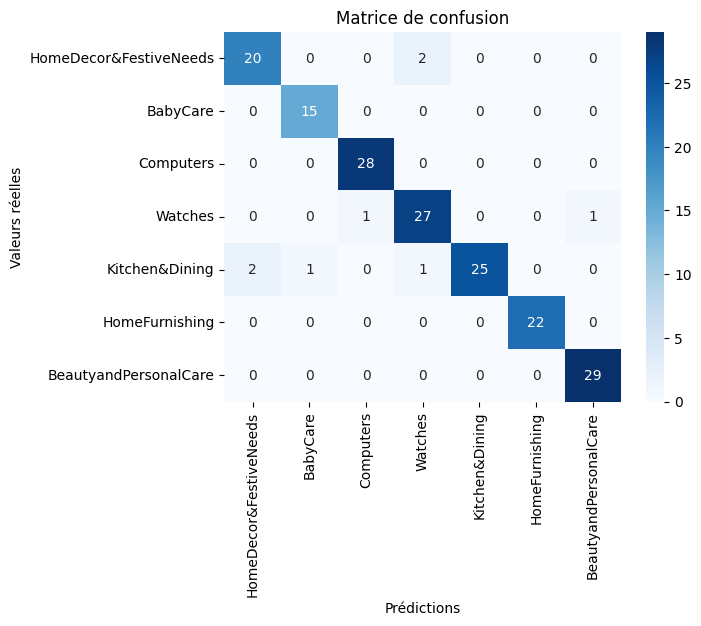

                        precision    recall  f1-score   support

HomeDecor&FestiveNeeds       0.91      0.91      0.91        22
              BabyCare       0.94      1.00      0.97        15
             Computers       0.97      1.00      0.98        28
               Watches       0.90      0.93      0.92        29
        Kitchen&Dining       1.00      0.86      0.93        29
        HomeFurnishing       1.00      1.00      1.00        22
 BeautyandPersonalCare       0.97      1.00      0.98        29

              accuracy                           0.95       174
             macro avg       0.95      0.96      0.95       174
          weighted avg       0.96      0.95      0.95       174



In [89]:
    # Convertir les étiquettes en vecteurs de classe
y_true = df_X_test['label']

    # Obtenir les noms de classe pour les étiquettes réelles
class_names = df_X_test['label'].unique()

    # Calculer la matrice de confusion
confusion_mtx = confusion_matrix(y_true, albef_predictions)

    # Afficher la matrice de confusion sous forme graphique
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, cmap='Blues', annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

# Afficher le rapport de classification
print(classification_report(y_true, albef_predictions, target_names=class_names))

### Save predictions

In [81]:
df_out = df_X_test.copy()
#df_out['bert_predictions'] = bert_predictions
df_out['bert_resnet_predictions'] = bert_resnet_predictions
df_out['albef_predictions'] = albef_predictions
df_out.to_csv(RESULTS_FOLDER + 'predictions_with_pretrained_models.csv', index=False)
